In [1]:
# https://www.kaggle.com/datasets/knightbearr/sales-product-data
import numpy as np
import statistics as st
import math as m
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter
import datetime as dt
import pandas as pd
from itertools import combinations
from collections import Counter

#### Import MySQL-enabled data in csv format and run some analysis on its characteristics

In [2]:
df_sp = pd.read_csv(r"C:\Users\Master\Documents\data_analytics\sales_product_data\sales_2019_silver_complete.csv")
print(df_sp.head(10))
df_sp.info()
print(df_sp.shape)

   order_id                     product  quantity   price     revenue  \
0    141234                      iPhone         1  700.00  700.000000   
1    141235    Lightning Charging Cable         1   14.95   14.950000   
2    141236            Wired Headphones         2   11.99   23.980000   
3    141237            27in FHD Monitor         1  149.99  149.990005   
4    141238            Wired Headphones         1   11.99   11.990000   
5    141239      AAA Batteries (4-pack)         1    2.99    2.990000   
6    141240      27in 4K Gaming Monitor         1  389.99  389.989990   
7    141241        USB-C Charging Cable         1   11.95   11.950000   
8    141242  Bose SoundSport Headphones         1   99.99   99.989998   
9    141243    Apple Airpods Headphones         1  150.00  150.000000   

            order_date                         customer_address  day_no  \
0  2019-01-22 21:25:00          944 Walnut St, Boston, MA 02215      22   
1  2019-01-28 14:15:00         185 Maple St, P

#### Rename some columns and assign as new df called df_sp1

In [3]:
df_sp1 = df_sp.rename(columns={'revenue': 'sales', 'quantity': 'units_sold'})

#### Convert order_date field into datetime format and then generate new columns for month and minute of the date

In [4]:
df_sp1['order_date'] = pd.to_datetime(df_sp1['order_date'])
df_sp1['min'] = df_sp1['order_date'].dt.minute
df_sp1['month'] = df_sp1['order_date'].dt.month

#### Identify main characteristics of df_sp1

In [5]:
print(df_sp1.head(3))
df_sp1.info()

   order_id                   product  units_sold   price   sales  \
0    141234                    iPhone           1  700.00  700.00   
1    141235  Lightning Charging Cable           1   14.95   14.95   
2    141236          Wired Headphones           2   11.99   23.98   

           order_date                       customer_address  day_no  \
0 2019-01-22 21:25:00        944 Walnut St, Boston, MA 02215      22   
1 2019-01-28 14:15:00       185 Maple St, Portland, OR 97035      28   
2 2019-01-17 13:33:00  538 Adams St, San Francisco, CA 94016      17   

   month_no  year_no  hour  week_day_no  day_name is_weekend street_address  \
0         1     2019    21            1   Tuesday          N  944 Walnut St   
1         1     2019    14            0    Monday          N   185 Maple St   
2         1     2019    13            3  Thursday          N   538 Adams St   

            city state_code  zipcode  min  month  
0         Boston         MA     2215   25      1  
1       Portlan

#### For additional checking, print some outputs from df_sp1 for order-date vs month  

In [6]:
print(df_sp1[['order_date', 'month']])

                order_date  month
0      2019-01-22 21:25:00      1
1      2019-01-28 14:15:00      1
2      2019-01-17 13:33:00      1
3      2019-01-05 20:33:00      1
4      2019-01-25 11:59:00      1
...                    ...    ...
185647 2019-12-11 20:58:00     12
185648 2019-12-01 12:01:00     12
185649 2019-12-09 06:43:00     12
185650 2019-12-03 10:39:00     12
185651 2019-12-21 21:45:00     12

[185652 rows x 2 columns]


#### Print the row with highest monthly sales 

In [26]:
print(df_sp1.groupby('month')['sales'].sum().sort_values(ascending=False).head(1))

month
12    4.608296e+06
Name: sales, dtype: float64


#### Chart for monthly sales

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


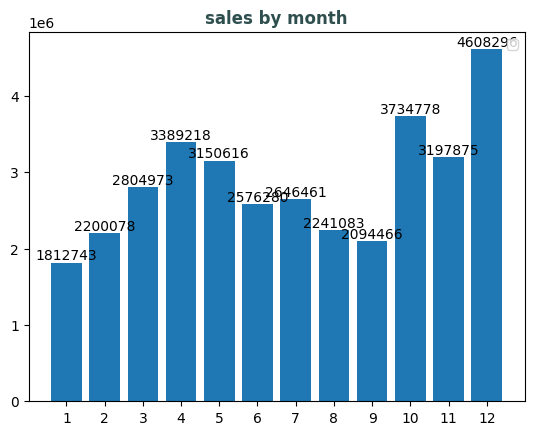

In [25]:
plt.title('sales by month', fontweight="bold", color='darkslategray')
results_month = df_sp1.groupby('month')['sales'].sum()
plt.bar(results_month.index, results_month)
for x,y in zip(results_month.index, results_month):
    label = "{:.0f}".format(y) # no decimal point
    plt.text(x, y, label, ha='center', va='bottom')
plt.xticks(results_month.index)
plt.legend()
plt.show()



#### Chart for city sales

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


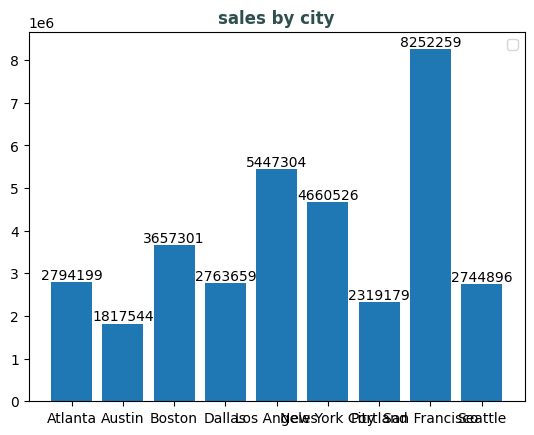

In [24]:
plt.title('sales by city', fontweight="bold", color='darkslategray')
results_city = df_sp1.groupby('city')['sales'].sum()
plt.bar(results_city.index, results_city)
for x,y in zip(results_city.index, results_city):
    label = "{:.0f}".format(y) # no decimal point
    plt.text(x, y, label, ha='center', va='bottom')
plt.xticks(results_city.index)
plt.legend()
plt.show()

#### Chart for hourly unique order counts

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


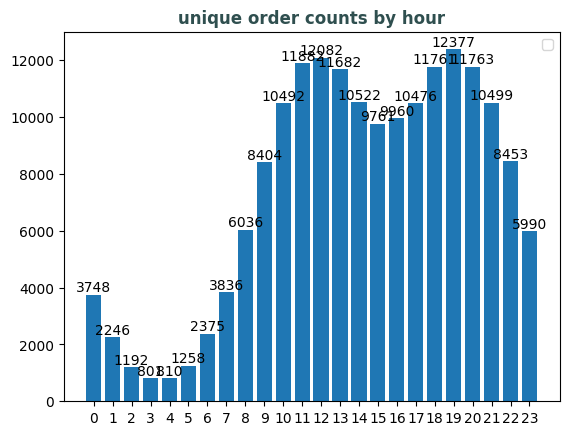

In [13]:
plt.title('unique order counts by hour', fontweight="bold", color='darkslategray')
results_hour = df_sp1.groupby('hour')['order_id'].nunique() # unique counts of order_id
hours = [hour for hour, df in df_sp1.groupby('hour')]
plt.bar(results_hour.index, results_hour)  
for x,y in zip(results_hour.index, results_hour):
    label = "{:.0f}".format(y) # no decimal point
    plt.text(x, y, label, ha='center', va='bottom')
plt.xticks(results_hour.index)
plt.legend()
plt.show()

### Export df_sp1 (optional)

In [15]:
df_sp1.to_csv(r"C:\Users\Master\Documents\data_analytics\sales_product_data\df_sp1.csv", index=True)

#### Creating only smaller data frame called df_combofinal for the combo baskets. First, create an intermediate base version df_combobase 

###### Problem: multiple rows exist for the same order id as some orders are combos of multiple producs. 
###### Perform selection indexed on order_id repeats. Use Keep=False in the argument to keep all repeats as True (by  boolean operator duplicated()). Non-repeat order_ids will be removed by default as the boolean will return false for all the non repeats
###### Documentation for boolean duplicated() operator here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html

In [18]:
df_combobase = df_sp1[df_sp1['order_id'].duplicated(keep=False)]
# join all the product attributes with comma ',' using transform join x
df_combobase['product_combo'] = df_combobase.groupby('order_id')['product'].transform(lambda x: ', '.join(x))
# now drop the duplicated rows of order_id and product combo
df_combofinal = df_combobase[['order_id','product_combo']].drop_duplicates()
df_combofinal.head()

C:\Users\Master\AppData\Local\Temp\ipykernel_32764\2564016890.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combobase['product_combo'] = df_combobase.groupby('order_id')['product'].transform(lambda x: ', '.join(x))


,order_id,product_combo
41,141275,"USB-C Charging Cable, Wired Headphones"
57,141290,"AA Batteries (4-pack), Apple Airpods Headphones"
133,141365,"Vareebadd Phone, Wired Headphones"
153,141384,"Google Phone, USB-C Charging Cable"
220,141450,"Bose SoundSport Headphones, Google Phone"


#### Export the df_combofinal data frame as order_combo.csv for subsequent commit into Tableau

In [19]:
df_combofinal.to_csv(r"C:\Users\Master\Documents\data_analytics\sales_product_data\order_combo.csv", index=False)

#### Optional step to export a result counter to check against Tableau visualization

In [21]:


# below not essential - only for reverse-checking
results_combo = df_combofinal.groupby('product_combo').count()['order_id'].sort_values(ascending=False)
print(results_combo)
results_combo.to_csv(r"C:\Users\Master\Documents\data_analytics\sales_product_data\results_combo.csv", index=True)

product_combo
iPhone, Lightning Charging Cable                                                              894
Google Phone, USB-C Charging Cable                                                            869
iPhone, Wired Headphones                                                                      374
USB-C Charging Cable, Vareebadd Phone                                                         318
Google Phone, Wired Headphones                                                                311
                                                                                             ... 
Apple Airpods Headphones, Google Phone, iPhone, Lightning Charging Cable, Wired Headphones      1
Apple Airpods Headphones, Google Phone, USB-C Charging Cable, Wired Headphones                  1
Apple Airpods Headphones, Google Phone, USB-C Charging Cable                                    1
Apple Airpods Headphones, Bose SoundSport Headphones, iPhone                                    1
27in F